In [41]:
# data wrangling/viz libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
# preprocessing libs
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
# modelling libs
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import lightgbm as lgb

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

pd.set_option('display.max_columns', None)


# Load Dataset

In [32]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

# Explaratory Data Analysis

Goals:
* Visualize various features: distribution, covariance w/ target feature
* Observe missing features

### EDA: Target Feature Exploration

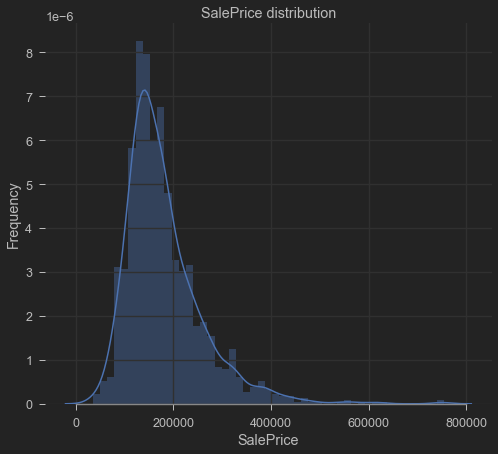

Skewness: 1.882876
Kurtosis: 6.536282


In [33]:
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.grid(True)
plt.show()

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

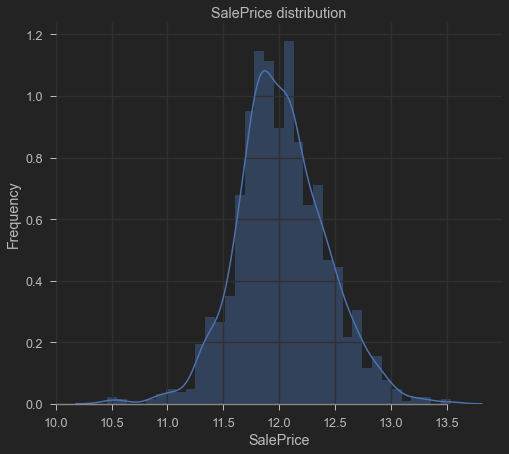

Skewness: 0.121347
Kurtosis: 0.809519


In [34]:
# normalize target feature
train["SalePrice"] = np.log1p(train["SalePrice"])

f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.grid(True)
plt.show()

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())


### EDA: Feature Correlation w/ Target Feature

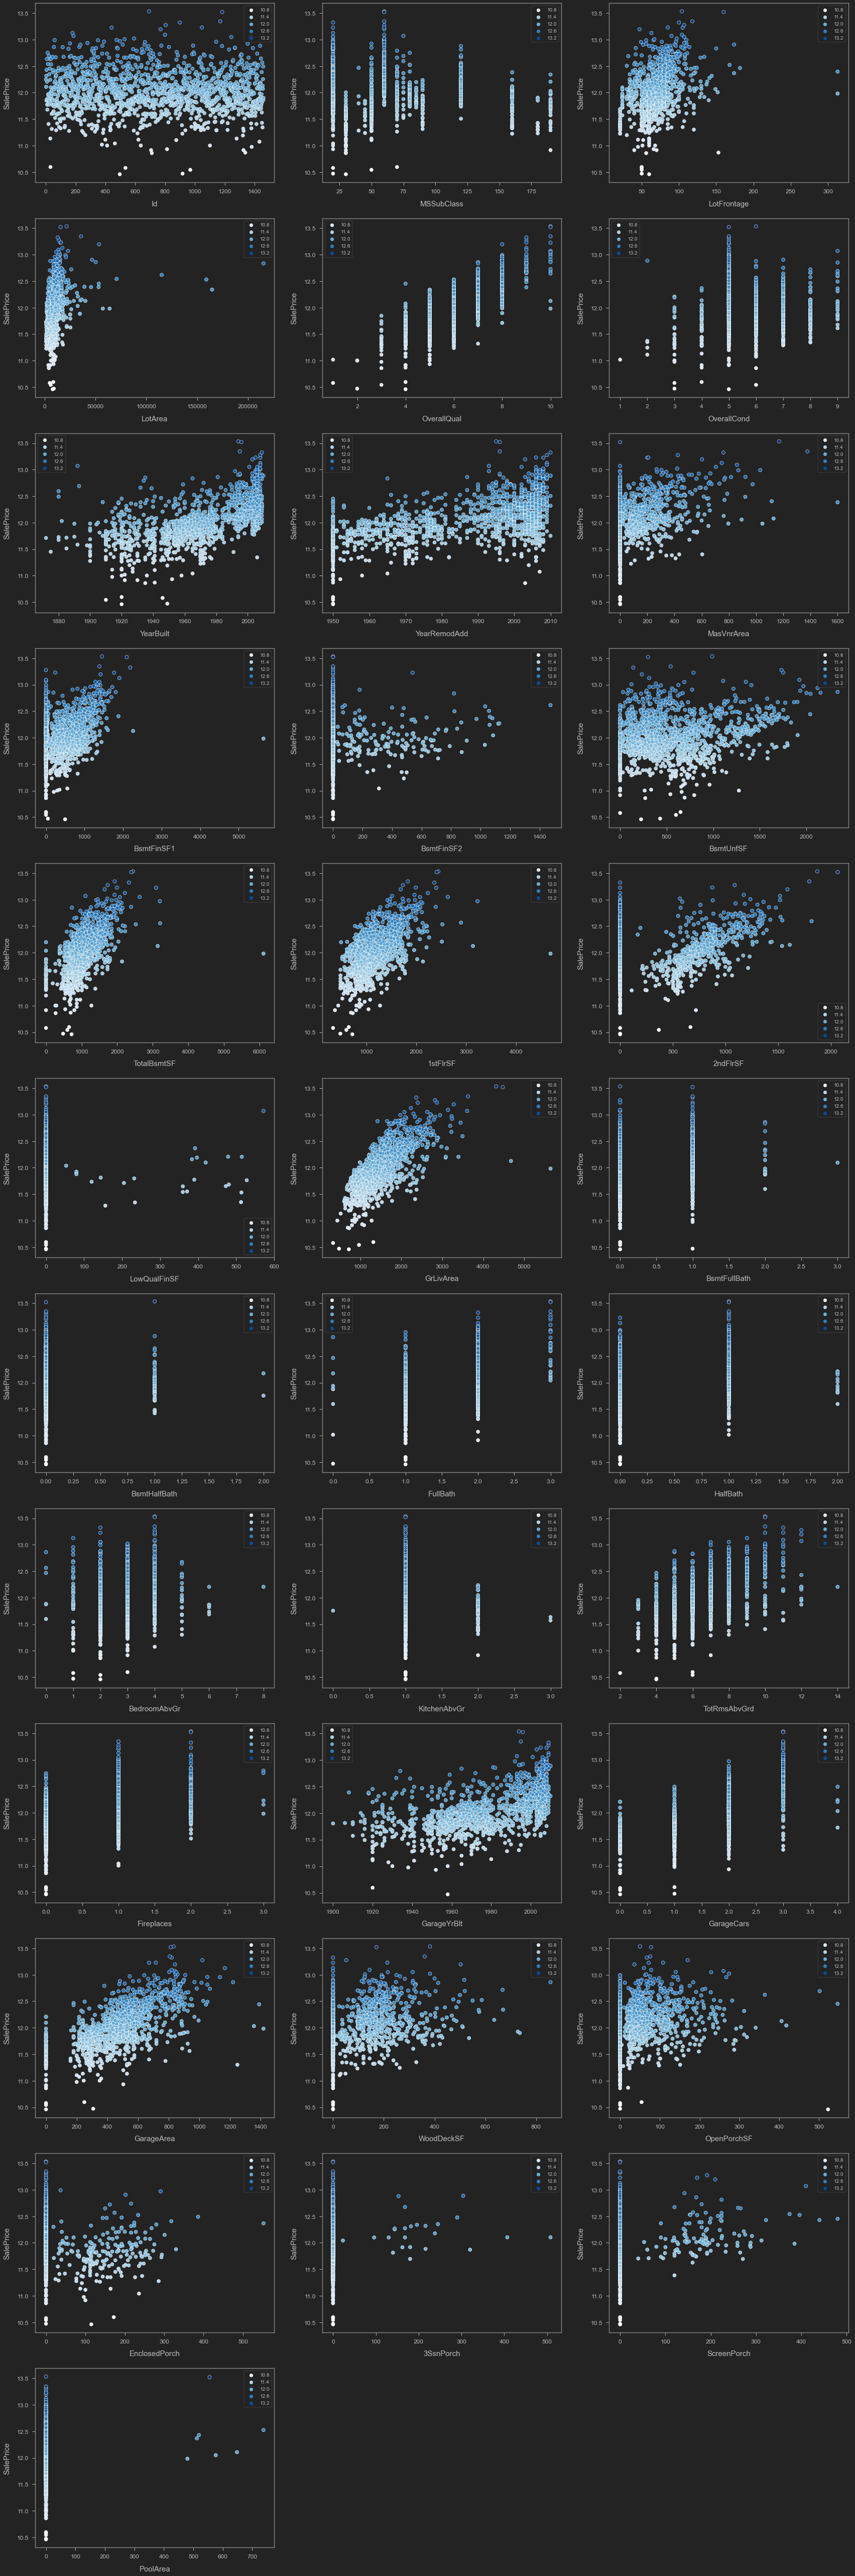

In [35]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)     
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(train[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()


### EDA: Visual Feature Correlation

<AxesSubplot:>

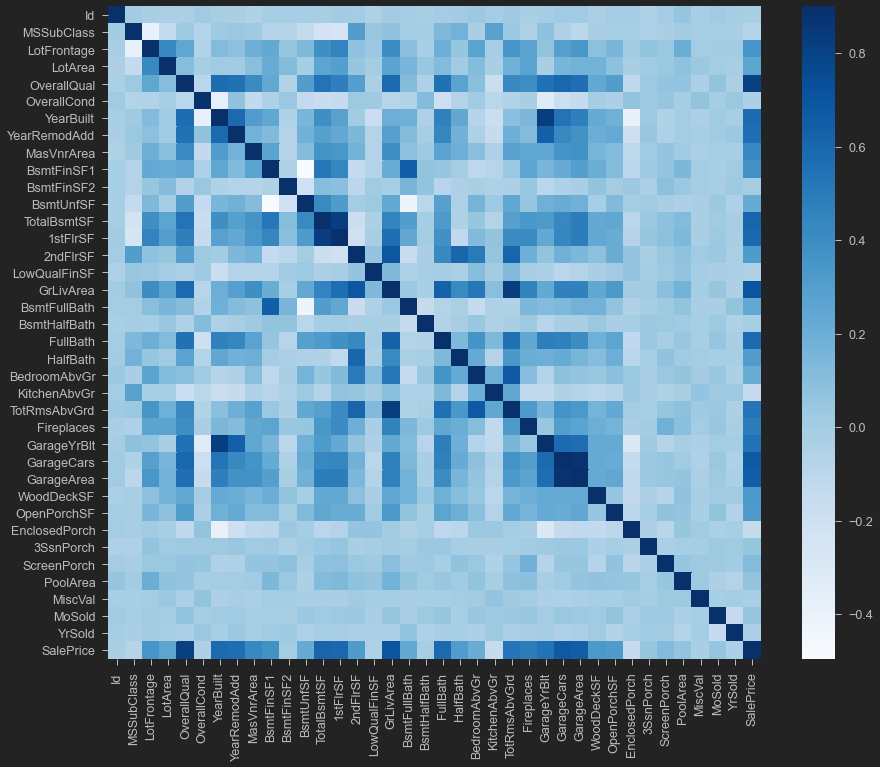

In [36]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

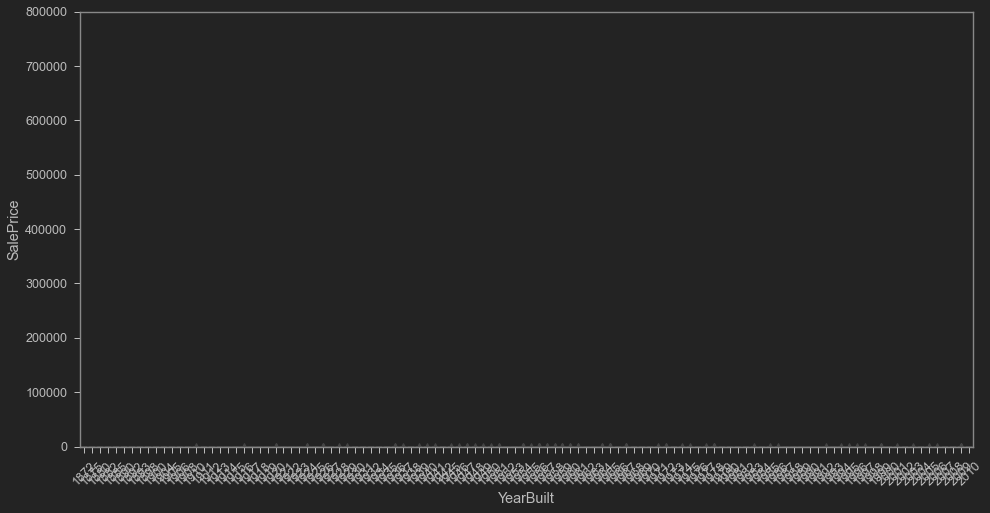

In [42]:
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=train['YearBuilt'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=45);


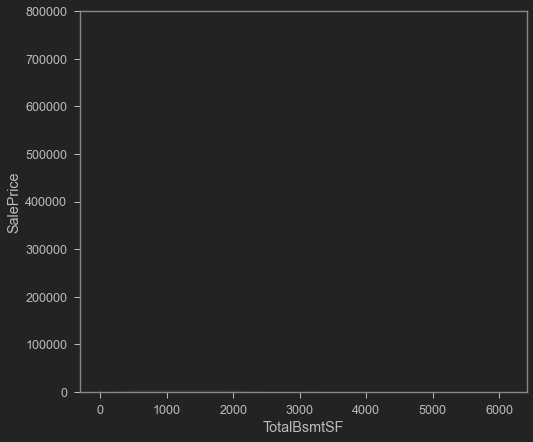

In [40]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', alpha=0.3, ylim=(0,800000));


### EDA: Target Feature Relation to Support Features

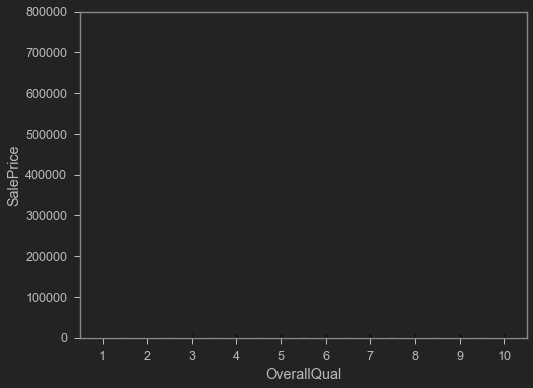

In [38]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.show()


In [4]:
data = pd.concat((train, test)).reset_index(drop=True)

# Feature Engineering/Imputation

In [5]:
# Handle missing values in features

data['MiscFeature'] = data['MiscFeature'].fillna('None')
data['Alley'] = data['Alley'].fillna('None')
data['Fence'] = data['Fence'].fillna('None')
data['LotFrontage'].fillna(value=data['LotFrontage'].median(), inplace=True)
data.SaleType.fillna(value='Other', inplace=True)

data['PoolQC'] = data['PoolQC'].fillna('None')
fill_na = {"None": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
data['PoolQC'].replace(fill_na, inplace=True)

data['FireplaceQu'] = data['FireplaceQu'].fillna('None')
fill_na = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
data['FireplaceQu'].replace(fill_na, inplace=True)

garage_values= data[['GarageYrBlt', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageCars', 'GarageArea']][data['GarageType'].isnull()]
for i in ['GarageCond', 'GarageFinish', 'GarageQual', 'GarageType']:
    data[i].fillna(value='None', inplace=True)
    
for i in ['GarageYrBlt', 'GarageCars', 'GarageArea']:
    data[i].fillna(value=0, inplace=True)

fill_na = {"None": 0, "Po": 1,"Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
data['GarageQual'].replace(fill_na, inplace=True)
data['GarageCond'].replace(fill_na, inplace=True)
fill_na = {"None": 0, "Unf": 1, "RFn": 2, "Fin": 3}
data['GarageFinish'].replace(fill_na, inplace=True)

basement_data = data[['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF']][data['BsmtQual'].isnull()]
for i in ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']:
    data[i].fillna(value='None', inplace=True)
    
for i in ['BsmtFinSF1', 'BsmtFinSF2','BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF']:
    data[i].fillna(value=0, inplace=True)

fill_na = {"None": 0, "Po": 1,"Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
data['BsmtCond'].replace(fill_na, inplace=True)
data['BsmtQual'].replace(fill_na, inplace=True)
fill_na = {"None": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}
data['BsmtExposure'].replace(fill_na, inplace=True)
fill_na = {"None": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
data['BsmtFinType1'].replace(fill_na, inplace=True)
data['BsmtFinType2'].replace(fill_na, inplace=True)

data['Street'].replace({'Grvl': 0, 'Pave': 1}, inplace=True)

data['CentralAir'].replace({'Y': 1, 'N': 0}, inplace=True)

fill_na = {"Po": 0,"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
data.HeatingQC.replace(fill_na, inplace=True)
data.ExterQual.replace(fill_na, inplace=True)
data.ExterCond.replace(fill_na, inplace=True)

fill_na = { 'Sev': 0, 'Mod': 1, 'Gtl': 2 }
data.LandSlope.replace(fill_na, inplace=True)

fill_na = { 'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3 }
data.LotShape.replace(fill_na, inplace=True)


fill_na = {20:'Class1', 30:'Class2', 40:'Class3', 45:'Class4', 50:'Class5', 60:'Class6', 70:'Class7', 75:'Class8', 80:'Class9', 85:'Class10', 90:'Class11', 120:'Class12',150:'Class13', 160:'Class14', 180:'Class15', 190:'Class16'}
data.MSSubClass.replace(fill_na, inplace=True)



# impute values
mode = data.Electrical.value_counts().idxmax()    
data['Electrical'].fillna(mode, inplace=True)

mode = data.MasVnrType.value_counts().idxmax() 
median = data.MasVnrArea.median()     

data['MasVnrType'].fillna(mode, inplace=True) 
data['MasVnrArea'].fillna(median, inplace=True)

mode = data.MSZoning.value_counts().idxmax()    
data['MSZoning'].fillna(mode, inplace=True)
data['MSZoning'].replace({'C (all)': 'C'}, inplace=True)

data.drop('Utilities', inplace=True, axis=1)

mode = data.Functional.value_counts().idxmax()    
data['Functional'].fillna(mode, inplace=True)

data.Exterior1st.fillna(value='Other', inplace=True)
data.Exterior2nd.fillna(value='Other', inplace=True)

mode = data.KitchenQual.value_counts().idxmax()    # 'TA'
data['KitchenQual'].fillna(value=mode, inplace=True)
fill_na = {"Po": 0,"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
data['KitchenQual'].replace(fill_na, inplace=True)

data_id = data['Id']
data.drop('Id', axis=1, inplace=True)

# Create new features

In [6]:
data['TotalSF'] = data['1stFlrSF'] + data['2ndFlrSF'] + data['GrLivArea'] + data['TotalBsmtSF']
data['Age'] = data.YrSold - data.YearBuilt
data['AgeRemod'] = data.YrSold - data.YearRemodAdd
data['GarageYrBlt'].replace({0.0: np.nan}, inplace=True)
data['GarageYrBlt'].fillna(data['YrSold'], inplace=True)
data['AgeGarage'] = data.YrSold - data.GarageYrBlt


data.Age       =  data.Age.map(lambda x: 0 if x < 0 else x)
data.AgeRemod  =  data.AgeRemod.map(lambda x: 0 if x < 0 else x)
data.AgeGarage =  data.AgeGarage.map(lambda x: 0 if x < 0 else x)

data.drop(['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt', 'MoSold','FireplaceQu'], axis=1, inplace=True)


col_drop = data['LotFrontage'][data['LotFrontage'] > 300].index
col_drop = np.append(col_drop, data['LotArea'][data['LotArea'] > 100000].index)
col_drop = np.append(col_drop, data['BsmtFinSF1'][data['BsmtFinSF1'] > 5000].index)
col_drop = np.append(col_drop, data['1stFlrSF'][data['1stFlrSF'] > 4000].index)
col_drop = np.append(col_drop, data['GrLivArea'][
    (data['GrLivArea'] > 4000) & (data['SalePrice'] < 12.5)
].index)
train_shape = train.shape[0]
test_shape = test.shape[0]
col_drop = col_drop[col_drop < train_shape]

data = data.drop(col_drop).reset_index(drop=True)

dropped_count = len(col_drop)
train_shape -= dropped_count

col_num = data.skew().index
col_skew = data[col_num].skew()[np.abs(data[col_num].skew()) > 0.5].index
data[col_skew] = np.log1p(data[col_skew])

col_cat = data.select_dtypes("object").columns
drop = []
for i in col_cat:
    drop += [ i+'_'+str(data[i].unique()[-1]) ]

# Encode Categorical Features

In [7]:
data = pd.get_dummies(data, columns=col_cat)
data.drop(drop, axis=1, inplace=True)

# Recreate Training and Testing Sets

In [8]:
X_train =  data[:-test_shape].drop(['SalePrice'], axis=1)
y_train =  data[:-test_shape]['SalePrice']
X_test  =  data[-test_shape:].drop(['SalePrice'], axis=1)
col_num = col_num.drop('SalePrice')

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train[col_num] = scaler.fit_transform(X_train[col_num])
X_test[col_num]  = scaler.transform(X_test[col_num])


# Create Models

There are 2 parts to the regression:
1. Stacked Average of base algorithms and a meta algorithm
2. Blending of the Stacked Average with a gradient boosting algorithm (LightGBM)

In [9]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)



model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
   
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        

        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)


stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

# Train Models

In [10]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))


[16:38:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [11]:
model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(X_test.values))


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [12]:
stacked_averaged_models.fit(X_train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test.values))
ensemble = stacked_pred*0.65 + lgb_pred*0.35

KeyboardInterrupt: 

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)
print(sub.head())